# Aerosol Optical Properties
I do all the mei calculations with `meipython`: https://github.com/scottprahl/miepython


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import miepython
from scipy.io import FortranFile
import os

In [2]:
# for writing binary files
def write_mie_file(filename, wavelength_new_nm, radii, w0_all, qext_all, g_all):
    if os.path.isfile(filename):
        raise Exception('Can not overwrite files')
    nw = len(wavelength_new_nm)
    nrad = len(radii)
    
    f = FortranFile(filename, 'w')

    f.write_record(np.array(nw,dtype=np.int32))
    f.write_record(wavelength_new_nm)

    f.write_record(np.array(nrad,dtype=np.int32))
    f.write_record(radii)

    f.write_record(w0_all)
    f.write_record(qext_all)
    f.write_record(g_all)

    f.close()

## H2SO4 from Atmos Twostr.f90

In [6]:
nrad = 50
radii = np.logspace(np.log10(0.0001),np.log10(2),nrad)
nw = 2
wavelength_new_nm = np.array([1,1000])
w0_all = np.empty((nrad,nw),np.float64)
qext_all = np.empty((nrad,nw),np.float64)
g_all = np.empty((nrad,nw),np.float64)

for i in range(nrad):
    w0_all[i,:] = 1
    qext_all[i,:] = 2
    g_all[i,:] = 0.8    

In [7]:
write_mie_file('atmos_H2SO4/mie_atmos_H2SO4.dat', wavelength_new_nm, radii, w0_all, qext_all, g_all)

## S8 from Atmos twostr.f90

In [8]:
nrad = 50
radii = np.logspace(np.log10(0.0001),np.log10(2),nrad)
nw = 4
wavelength_new_nm = np.array([1,350,350.1,1000])
w0_all = np.empty((nrad,nw),np.float64)
qext_all = np.empty((nrad,nw),np.float64)
g_all = np.empty((nrad,nw),np.float64)

for i in range(nrad):
    w0_all[i,:] = np.array([0.5,0.5,1,1])
    qext_all[i,:] = 2
    g_all[i,:] = 0.8  

In [9]:
write_mie_file('atmos_S8/mie_atmos_S8.dat', wavelength_new_nm, radii, w0_all, qext_all, g_all)

## Khare_tholins.dat (hydrocarbon aersols)

In [3]:
fil = open('khare1984/khare_tholins.dat')
lines = fil.readlines()
fil.close()

wavelength = [] # microns
m_real = []
m_imag = []
for line in lines[13:]:
    tmp = line.split()
    wavelength.append(float(tmp[1]))
    m_real.append(float(tmp[2]))
    m_imag.append(float(tmp[3]))
    
wavelength = np.array(wavelength) # this is micro meter
wavelength_nm = wavelength*1e3
m_real = np.array(m_real)
m_imag = np.array(m_imag)

In [4]:
radius = 0.9
x = 2 * np.pi * radius / wavelength
m = m_real - 1j*m_imag
qext, qsca, qback, g = miepython.mie(m, x)
w0 = qsca/qext

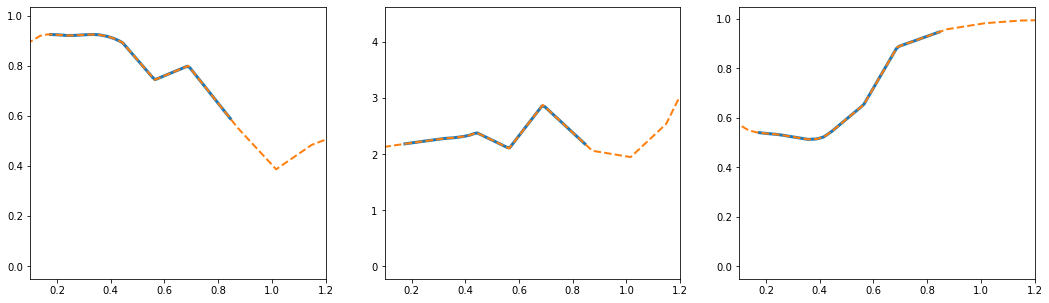

In [5]:
# wavl, wavu, w0_atmos, qext_atmos, g_atmos = np.loadtxt('fitmythol0001.DAT').T
wavl, wavu, w0_atmos, qext_atmos, g_atmos = np.loadtxt('fitmythol09.DAT').T

fig,[ax,ax1,ax2] = plt.subplots(1,3,figsize=[18,5],sharex=True)

ax.plot(wavl/10/1e3,g_atmos,lw=3)
ax.plot(wavelength,g,'--',lw=2)

ax1.plot(wavl/10/1e3,qext_atmos,lw=3)
ax1.plot(wavelength,qext,'--',lw=2)

ax2.plot(wavl/10/1e3,w0_atmos,lw=3)
ax2.plot(wavelength,w0,'--',lw=2)

ax.set_xlim(.1,1.2)

plt.show()

In [9]:
# interpolate the data to a new grid
# between 20.7 nm and 920000 nm
nw = 500
wavelength_new = np.logspace(np.log10(0.0207), np.log10(920.0),nw)

wavelength_new_nm = wavelength_new*1e3
m_real_new = np.interp(wavelength_new,wavelength,m_real)
m_imag_new = np.interp(wavelength_new,wavelength,m_imag)

# for r = 0.001 micrometer to 2 micrometers
# log space, 50 intervals
nrad = 50

radii = np.logspace(np.log10(0.0001),np.log10(2),nrad)

In [10]:
w0_all = np.empty((nrad,nw),np.float64)
qext_all = np.empty((nrad,nw),np.float64)
g_all = np.empty((nrad,nw),np.float64)

for i,radius in enumerate(radii):
    x = 2 * np.pi * radius / wavelength_new
    m = m_real_new - 1j*m_imag_new
    qext, qsca, qback, g = miepython.mie(m, x)
    w0 = qsca/qext
    
    w0_all[i] = w0
    qext_all[i] = qext
    g_all[i] = g

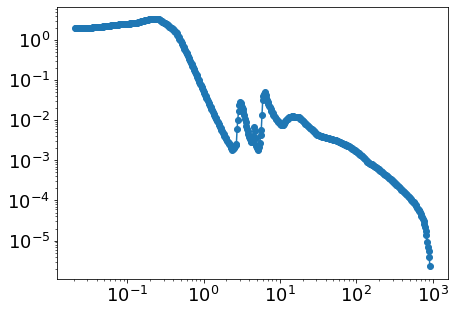

In [15]:
ind = np.argmin(np.abs(radii-0.1))

plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(wavelength_new_nm/1e3,qext_all[ind,:], 'o-')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim()
plt.show()

In [16]:
write_mie_file('test1.dat', wavelength_new_nm, radii, w0_all, qext_all, g_all)

# Palmer 1975 (H2SO4)

In [12]:
fil = open('palmer1975/palmer_williams_h2so4.dat')
lines = fil.readlines()
fil.close()

wavelength = [] # microns
m_real = []
m_imag = []
for line in lines[16:243]:
    tmp = line.split()
    wavelength.append(float(tmp[1]))
    m_real.append(float(tmp[7]))
    
for line in lines[248:-1]:
    tmp = line.split()
    m_imag.append(float(tmp[7]))
    
wavelength = np.array(wavelength) # this is micro meter
ind = np.argsort(wavelength)
wavelength = wavelength[ind]

wavelength_nm = wavelength*1e3
m_real = np.array(m_real)[ind]
m_imag = np.array(m_imag)[ind]

In [32]:
radius = .01
x = 2 * np.pi * radius / wavelength
m = m_real - 1j*m_imag
qext, qsca, qback, g = miepython.mie(m, x)
w0 = qsca/qext

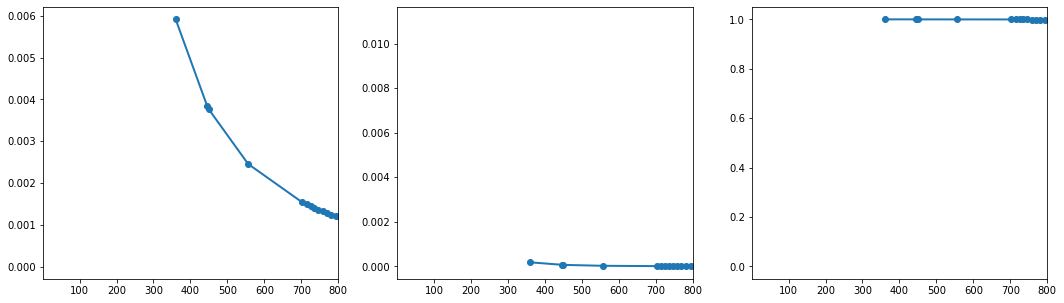

In [33]:
fig,[ax,ax1,ax2] = plt.subplots(1,3,figsize=[18,5],sharex=True)

ax.plot(wavelength_nm,g,'o-',lw=2)

ax1.plot(wavelength_nm,qext,'o-',lw=2)

ax2.plot(wavelength_nm,w0,'o-',lw=2)

ax.set_xlim(1,800)

plt.show()

In [35]:
# interpolate the data to a new grid
# between 20.7 nm and 1000 nm
nw = 200
wavelength_new = np.linspace(0.36,25.0,nw)

wavelength_new_nm = wavelength_new*1e3
m_real_new = np.interp(wavelength_new,wavelength,m_real)
m_imag_new = np.interp(wavelength_new,wavelength,m_imag)

# for r = 0.001 micrometer to 2 micrometers
# log space, 50 intervals
nrad = 50

radii = np.logspace(np.log10(0.0001),np.log10(2),nrad)

In [36]:
w0_all = np.empty((nrad,nw),np.float64)
qext_all = np.empty((nrad,nw),np.float64)
g_all = np.empty((nrad,nw),np.float64)

for i,radius in enumerate(radii):
    x = 2 * np.pi * radius / wavelength_new
    m = m_real_new - 1j*m_imag_new
    qext, qsca, qback, g = miepython.mie(m, x)
    w0 = qsca/qext
    
    w0_all[i] = w0
    qext_all[i] = qext
    g_all[i] = g

In [15]:
# write_mie_file('mie_palmer1975.dat', wavelength_new_nm, radii, w0_all, qext_all, g_all)